In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds   
import os 

In [3]:
# TDL : 
# strat update de la cov
# checker le calcul dynamique des poids 
# calculer les metrics de mon portefeuille 

# créer un module avec les fonctions utiles

# add transaction costs and volatility scaling cf. 4.4 dans l'article 

In [4]:
# article du papier, (préférer celui de CHOUEIFATY - Toward Maximum Diversification)
# https://www.tandfonline.com/doi/epdf/10.1080/23322039.2018.1427533?needAccess=true

In [5]:
# Data loading 

# from 2006 to 2020 daily 
# test from 2011 to end of april 2020

tickers = ['VTI', 'AGG', 'DBC', '^VIX']
start = "2006-01-01"
end = "2020-12-31"
period = "1d"
df_original = yf.download(tickers, start=start, end=end, period=period)['Adj Close']

df_original.index = df_original.index.strftime("%Y-%m-%d")

[*********************100%***********************]  4 of 4 completed


In [27]:
window = 50

In [6]:
# data cleaning & creating rets and ma
df = df_original.copy()

cols_rets = [f"{asset}_r" for asset in tickers]
df[cols_rets] = df[tickers].pct_change()

cols_mavg = [f"{col}_mavg_50d" for col in cols_rets]
df[cols_mavg] = df[cols_rets].rolling(window=window).mean()

df.dropna(inplace=True)

df

Ticker,AGG,DBC,VTI,^VIX,VTI_r,AGG_r,DBC_r,^VIX_r,VTI_r_mavg_50d,AGG_r_mavg_50d,DBC_r_mavg_50d,^VIX_r_mavg_50d
Date,,,,,,,,,,,,
2006-04-19,55.700779,22.356937,46.467979,11.320000,0.002988,0.000916,0.009746,-0.007018,0.000813,-0.000212,0.001441,-0.001952
2006-04-20,55.615891,22.097980,46.531868,11.640000,0.001375,-0.001524,-0.011583,0.028269,0.001035,-0.000229,0.001788,-0.002230
2006-04-21,55.610210,22.564108,46.510544,11.590000,-0.000458,-0.000102,0.021094,-0.004296,0.000882,-0.000221,0.002295,-0.001198
2006-04-24,55.819721,22.115246,46.375702,11.750000,-0.002899,0.003767,-0.019893,0.013805,0.000862,-0.000157,0.001709,-0.001374
2006-04-25,55.632862,22.184299,46.226627,11.750000,-0.003214,-0.003348,0.003122,0.000000,0.000757,-0.000182,0.002136,-0.000993
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,106.353722,13.794738,182.168060,23.309999,0.001710,-0.000678,0.012517,-0.037969,0.001588,0.000074,0.001958,-0.000181
2020-12-24,106.452942,13.832635,182.472763,21.530001,0.001673,0.000933,0.002747,-0.076362,0.001754,0.000080,0.001877,-0.001961
2020-12-28,106.471024,13.747366,183.627274,21.700001,0.006327,0.000170,-0.006164,0.007896,0.001874,0.000101,0.001693,-0.002235


In [7]:
cov = df[cols_mavg].cov()
sigma = df[cols_mavg].std()

print(cov)
print(sigma)

Ticker           VTI_r_mavg_50d  AGG_r_mavg_50d  DBC_r_mavg_50d  \
Ticker                                                            
VTI_r_mavg_50d     2.249227e-06    1.559185e-08    1.766662e-06   
AGG_r_mavg_50d     1.559185e-08    1.147992e-07   -6.545212e-08   
DBC_r_mavg_50d     1.766662e-06   -6.545212e-08    3.961852e-06   
^VIX_r_mavg_50d   -9.258946e-06   -2.142813e-07   -8.196074e-06   

Ticker           ^VIX_r_mavg_50d  
Ticker                            
VTI_r_mavg_50d     -9.258946e-06  
AGG_r_mavg_50d     -2.142813e-07  
DBC_r_mavg_50d     -8.196074e-06  
^VIX_r_mavg_50d     6.783629e-05  
Ticker
VTI_r_mavg_50d     0.001500
AGG_r_mavg_50d     0.000339
DBC_r_mavg_50d     0.001990
^VIX_r_mavg_50d    0.008236
dtype: float64


In [8]:
sigma_annualized = sigma * np.sqrt(252)
cov_annualized = cov * 252   

print(cov_annualized)
print(sigma_annualized)

Ticker           VTI_r_mavg_50d  AGG_r_mavg_50d  DBC_r_mavg_50d  \
Ticker                                                            
VTI_r_mavg_50d         0.000567        0.000004        0.000445   
AGG_r_mavg_50d         0.000004        0.000029       -0.000016   
DBC_r_mavg_50d         0.000445       -0.000016        0.000998   
^VIX_r_mavg_50d       -0.002333       -0.000054       -0.002065   

Ticker           ^VIX_r_mavg_50d  
Ticker                            
VTI_r_mavg_50d         -0.002333  
AGG_r_mavg_50d         -0.000054  
DBC_r_mavg_50d         -0.002065  
^VIX_r_mavg_50d         0.017095  
Ticker
VTI_r_mavg_50d     0.023808
AGG_r_mavg_50d     0.005379
DBC_r_mavg_50d     0.031597
^VIX_r_mavg_50d    0.130747
dtype: float64


In [9]:
# fonctions qui calculent les poids de la strat 

def diversification_ratio(w, cov, sigma):
    wT_sigma = w.T @ sigma 
    wT_cov_w = w.T @ cov @ w 
    return wT_sigma / (np.sqrt(wT_cov_w))

def get_weights_md(cov, sigma, bounds=None):
    """
    We get the weights by minimizing the negative diversification ratio
    """
    
    n_assets = len(sigma)
    w0 = np.ones(n_assets) / n_assets 

    # Defining the loss and the weight constraint

    def loss(w, cov, sigma):
        return - diversification_ratio(w, cov, sigma)

    def con_1(w):
        return w.sum() - 1 
    
    cons = {'type': 'eq', 'fun': con_1}
            
    res = minimize(
        fun = loss,
        x0 = w0,
        constraints=cons,
        args=(cov, sigma),
        bounds=bounds,
        method='SLSQP'
    )

    return res.x  

In [10]:
# exemple : test sur tout le dataset 

bounds = tuple((0, 1) for _ in range(len(sigma))) # bounds pour le long only
get_weights_md(cov, sigma, bounds=bounds)

array([0.31078388, 0.53454689, 0.08405043, 0.0706188 ])

In [11]:
# Old version - Penser à implémenter une version plus rapide avec rolling et cov  

def optimize_portfolio_md(returns, rolling_window=50, bounds=None):
    """
    Prend en entrée le df des returns rolling
    """

    n_days, n_assets = returns.shape
    
    if n_days < rolling_window:
        ValueError(f"please input n_days bigger than {rolling_window}")

    days_rolling = n_days - rolling_window

    #initializating the weight matrix 
    weights_matrix = pd.DataFrame(np.zeros(shape=(days_rolling, n_assets)))

    if isinstance(returns, pd.DataFrame):
        weights_matrix.index = returns.index[rolling_window:]
        weights_matrix.columns = returns.columns

    for day in range(days_rolling):

        # estimatinng the volatility and the covariance matrix on the window 
        rets = returns.iloc[day:day + rolling_window,:]
        cov = rets.cov() # se demander si il y a pas une manière efficace de l'updater 

        # def cov_matrix_update(cov_old, ) - https://math.stackexchange.com/questions/1147084/dynamic-update-of-co-variance-matrix-upon-new-sample 

        sigma = np.sqrt(np.diag(cov)) 
        
        # computing the weights for the day by maximizing the diversification ratio 

        weights_matrix.iloc[day,:] = get_weights_md(cov, sigma, bounds=bounds)

    return weights_matrix    

In [73]:
returns_mavg = df[cols_mavg]

bounds = tuple((0, 1) for _ in range(len(sigma)))
weights_matrix = optimize_portfolio_md(returns_mavg, bounds=bounds, rolling_window=window)


KeyError: 0

In [13]:
# saving the weights

path_dir = os.getcwd()
version = 1
name_output = f"weights_md_{version}.csv"
path = path_dir + "\\output\\" + name_output
weights_matrix.to_csv(path)

In [14]:
weights_matrix["check"] = np.isclose(weights_matrix.iloc[:, 0:4].sum(axis=1), 1.0, atol=1e-6)

all_rows_valid = weights_matrix["check"].all()
print("All rows sum to 1" if all_rows_valid else "Some rows do not sum to 1.")

weights_matrix

All rows sum to 1


Ticker,VTI_r_mavg_50d,AGG_r_mavg_50d,DBC_r_mavg_50d,^VIX_r_mavg_50d,check
Date,,,,,
2006-06-29,0.732687,0.176087,0.000000e+00,0.091226,True
2006-06-30,0.667544,0.249825,0.000000e+00,0.082631,True
2006-07-03,0.574633,0.356238,2.755324e-12,0.069129,True
2006-07-05,0.532461,0.404681,6.350452e-13,0.062858,True
2006-07-06,0.526953,0.411050,0.000000e+00,0.061998,True
...,...,...,...,...,...
2020-12-23,0.366704,0.515250,4.263137e-02,0.075415,True
2020-12-24,0.385620,0.490724,4.492895e-02,0.078727,True
2020-12-28,0.395395,0.467771,5.515330e-02,0.081681,True


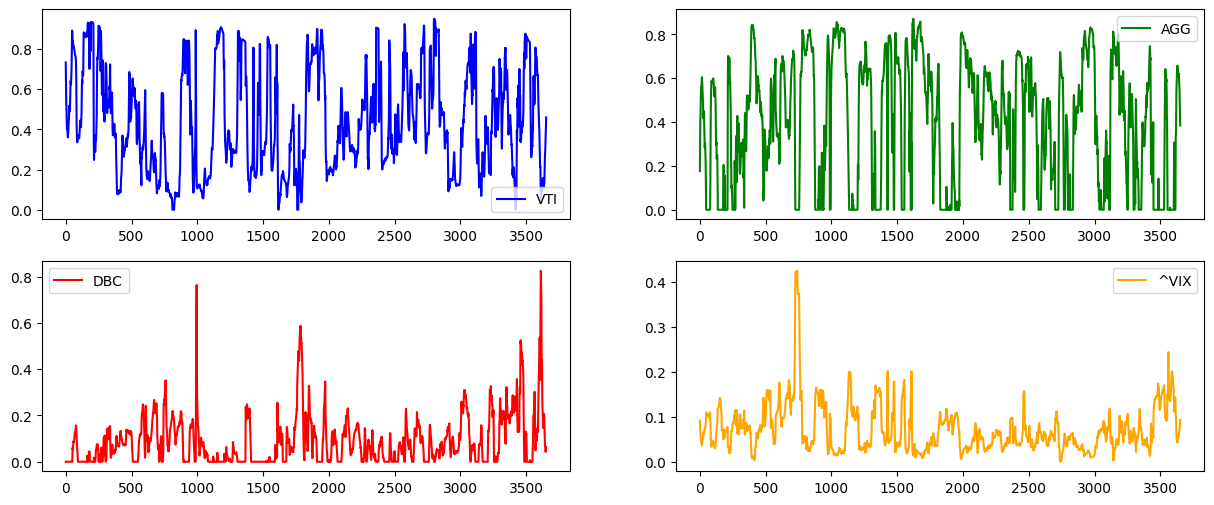

In [15]:
fig, axs = plt.subplots(2,2, figsize=(15, 6))
colors = ['blue', 'green', 'red', 'orange']
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].plot(weights_matrix.iloc[:,i].values, label=tickers[i], color=colors[i])
    axs[i].legend()

In [24]:
# getting the returns

returns = df[cols_rets]

column_mapping = dict(zip(weights_matrix.columns[0:4], cols_rets))

weights_renamed = weights_matrix.iloc[:,0:4].rename(columns=column_mapping)

common_dates = returns.index.intersection(weights_matrix.index)

weighted_returns = weights_renamed.loc[common_dates] * returns.loc[common_dates]
portfolio_md_rets = weighted_returns.sum(axis=1).to_frame("portfolio_md_rets")
portfolio_md_rets["cumulative_rets"] = (1 + portfolio_md_rets.loc[:,"portfolio_md_rets"]).cumprod() - 1 
portfolio_md_rets

,portfolio_md_rets,cumulative_rets
Date,,
2006-06-29,0.000667,0.000667
2006-06-30,-0.000026,0.000642
2006-07-03,0.004798,0.005442
2006-07-05,-0.000260,0.005181
2006-07-06,-0.000097,0.005083
...,...,...
2020-12-23,-0.002052,2.557846
2020-12-24,-0.004786,2.540820
2020-12-28,0.002886,2.551039


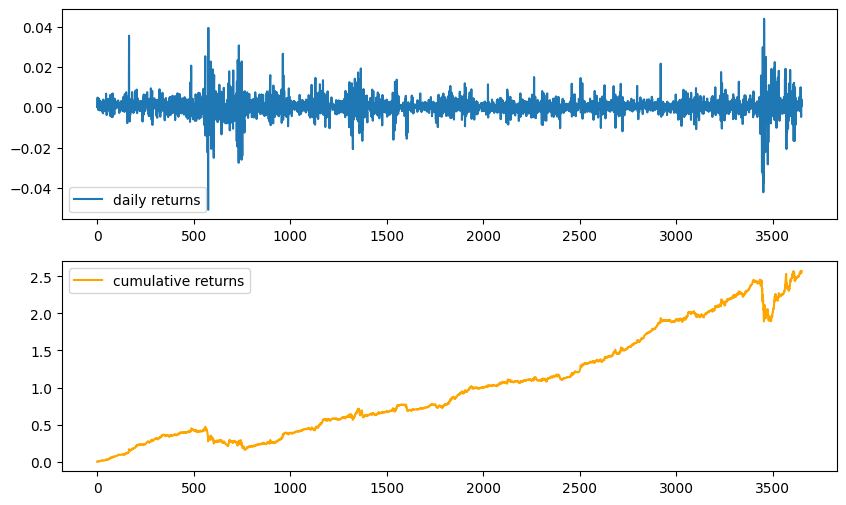

In [25]:
fig, axs = plt.subplots(2,1, figsize=(10, 6))

axs[0].plot(portfolio_md_rets["portfolio_md_rets"].values, label="daily returns")
axs[0].legend()
axs[1].plot(portfolio_md_rets["cumulative_rets"].values, label="cumulative returns", color='orange')
axs[1].legend()

In [26]:
portfolio_return = (1 + portfolio_md_rets["portfolio_md_rets"].mean()) ** 252 - 1
portfolio_volatility = portfolio_md_rets["portfolio_md_rets"].std() * np.sqrt(252)
sharpe = portfolio_return / portfolio_volatility

print(f"Annualized Return: {portfolio_return:.2%}")
print(f"Annualized Volatility: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")



Annualized Return: 9.49%
Annualized Volatility: 7.65%
Sharpe Ratio: 1.24
